<a href="https://colab.research.google.com/github/tomyrso/mat281_portfolio/blob/master/docs/projects/ProyectoFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataset Description

In this competition your task is to predict whether a passenger was transported to an alternate dimension during the Spaceship Titanic's collision with the spacetime anomaly. To help you make these predictions, you're given a set of personal records recovered from the ship's damaged computer system.

## File and Data Field Descriptions
train.csv - Personal records for about two-thirds (~8700) of the passengers, to be used as training data.
- PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
- HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.
- CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
- Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
- Destination - The planet the passenger will be debarking to.
- Age - The age of the passenger.
- VIP - Whether the passenger has paid for special VIP service during the voyage.
- RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
- Name - The first and last names of the passenger.
- Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

test.csv - Personal records for the remaining one-third (~4300) of the passengers, to be used as test data. Your task is to predict the value of Transported for the passengers in this set.

sample_submission.csv - A submission file in the correct format.
- PassengerId - Id for each passenger in the test set.
- Transported - The target. For each passenger, predict either True or False.

In [ ]:
#pip install tensorflow

In [ ]:
!pip install xgboost

In [ ]:
# Librerias a usar

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_auc_score, precision_score, recall_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler
from lightgbm import LGBMClassifier
from joblib import dump
import xgboost as xgb
from sklearn.linear_model import LogisticRegression

In [ ]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample = pd.read_csv('sample_submission.csv')

Veamos como son los datos

In [ ]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


También para el test

In [ ]:
test.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


In [ ]:
sample.head()

,PassengerId,Transported
0,0013_01,False
1,0018_01,False
2,0019_01,False
3,0021_01,False
4,0023_01,False


## Limpieza de datos

Eliminamos las columnas irrelevantes.

In [ ]:
train.drop(['Name', 'PassengerId'], axis=1, inplace=True)
test_ids = test['PassengerId']
test.drop(['Name', 'PassengerId'], axis=1, inplace=True)

Rellenamos los valores nulos

In [ ]:
train['HomePlanet'] = train['HomePlanet'].fillna('Unknown')
test['HomePlanet'] = test['HomePlanet'].fillna('Unknown')

train['CryoSleep'] = train['CryoSleep'].fillna(False)
test['CryoSleep'] = test['CryoSleep'].fillna(False)

train['Destination'] = train['Destination'].fillna('Unknown')
test['Destination'] = test['Destination'].fillna('Unknown')

train['Cabin'] = train['Cabin'].fillna('Unknown/0/U')
test['Cabin'] = test['Cabin'].fillna('Unknown/0/U')

train['Age'] = train['Age'].fillna(train['Age'].median())
test['Age'] = test['Age'].fillna(test['Age'].median())

spending_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
# Rellenar columnas de gasto
for col in spending_cols:
    train[col] = train[col].fillna(0)
    test[col] = test[col].fillna(0)

<ipython-input-72-9cdd97ad49df>:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train['CryoSleep'] = train['CryoSleep'].fillna(False)
<ipython-input-72-9cdd97ad49df>:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test['CryoSleep'] = test['CryoSleep'].fillna(False)


Separamos los valores de la Columna 'Cabin' en tres nuevas columnas

In [ ]:
train[['Deck', 'Num', 'Side']] = train['Cabin'].str.split('/', expand=True)
test[['Deck', 'Num', 'Side']] = test['Cabin'].str.split('/', expand=True)
train.drop(['Cabin'], axis=1, inplace=True)
test.drop(['Cabin'], axis=1, inplace=True)

Convertimos las columnas categóricas a numéricas

In [ ]:
categorical_cols = ['HomePlanet', 'Destination', 'Deck', 'Side']
category_mappings = {}
for col in categorical_cols:
    train[col] = train[col].astype('category')
    category_mappings[col] = dict(enumerate(train[col].cat.categories))
    test[col] = test[col].astype('category').cat.codes

for col, mapping in category_mappings.items():
    print(f"Mapping for {col}: {mapping}")

Mapping for HomePlanet: {0: 'Earth', 1: 'Europa', 2: 'Mars', 3: 'Unknown'}
Mapping for Destination: {0: '55 Cancri e', 1: 'PSO J318.5-22', 2: 'TRAPPIST-1e', 3: 'Unknown'}
Mapping for Deck: {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'T', 8: 'Unknown'}
Mapping for Side: {0: 'P', 1: 'S', 2: 'U'}


In [ ]:
# Verificar la cantidad de valores en cada columna
print("\nValores nulos después del procesamiento (train):")
print(train.isnull().sum())


Valores nulos después del procesamiento (train):
HomePlanet        0
CryoSleep         0
Destination       0
Age               0
VIP             203
RoomService       0
FoodCourt         0
ShoppingMall      0
Spa               0
VRDeck            0
Transported       0
Deck              0
Num               0
Side              0
dtype: int64


## Análisis Exploratorio

In [ ]:
# Graficar distribuciones relevantes
def plot_distribution(data, column, hue=None, title='', xlabel='', ylabel='Cantidad'):
    sns.countplot(data=data, x=column, hue=hue, palette='pastel')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

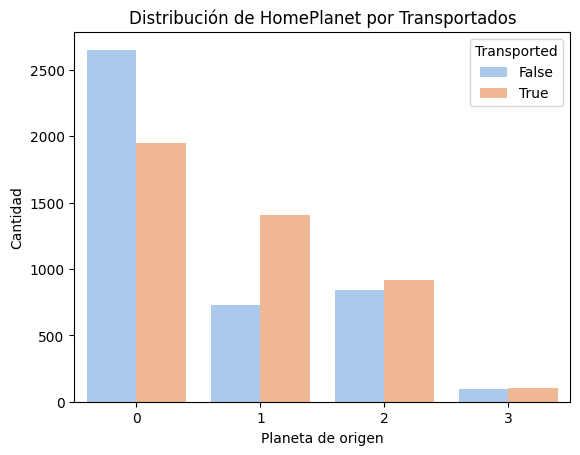

In [ ]:
# Graficar HomePlanet vs Transported
plot_distribution(
    train,
    'HomePlanet',
    hue='Transported',
    title='Distribución de HomePlanet por Transportados',
    xlabel='Planeta de origen'
)

Podemos ver que las personas que tienen de planeta de origen la tierra son las que más fueron transportadas, pero es simplemente explicable gracias a que la tierra es el lugar de donde la maypria de las personas provienen.

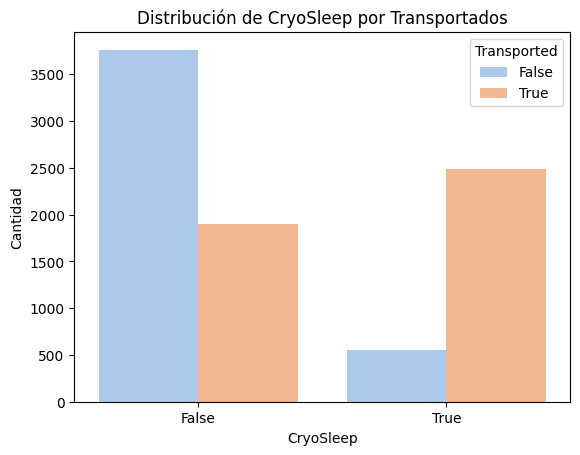

In [ ]:
# Graficar CryoSleep vs Transported
plot_distribution(
    train,
    'CryoSleep',
    hue='Transported',
    title='Distribución de CryoSleep por Transportados',
    xlabel='CryoSleep'
)

Se observa que la mayoria de la gente que si fue teletransportada estaba en CryoSleep

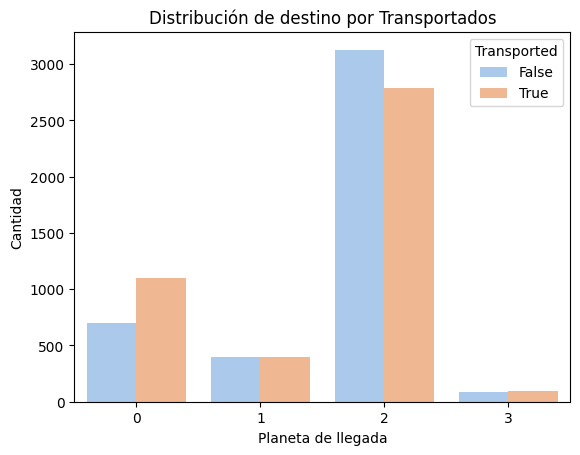

In [ ]:
# Graficar Destination vs Transported
plot_distribution(
    train,
    'Destination',
    hue='Transported',
    title='Distribución de destino por Transportados',
    xlabel='Planeta de llegada'
)

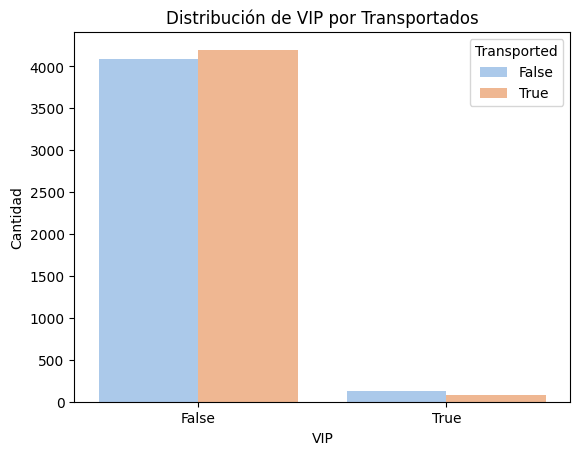

In [ ]:
# Graficar VIP vs Transported
plot_distribution(
    train,
    'VIP',
    hue='Transported',
    title='Distribución de VIP por Transportados',
    xlabel='VIP'
)

<ipython-input-15-1d24c7f3a36b>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x=column, hue=hue, palette='pastel')


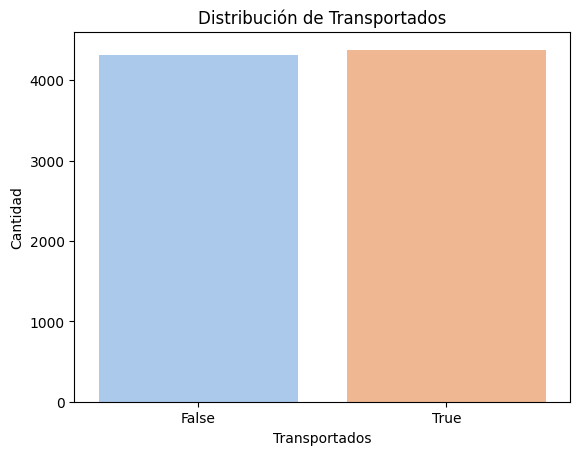

In [ ]:
# Graficar distribución general de Transportados
plot_distribution(
    train,
    'Transported',
    title='Distribución de Transportados',
    xlabel='Transportados'
)

Observemos la correlación entre las variables numéricas y cómo se relacionan con 'Transported'.

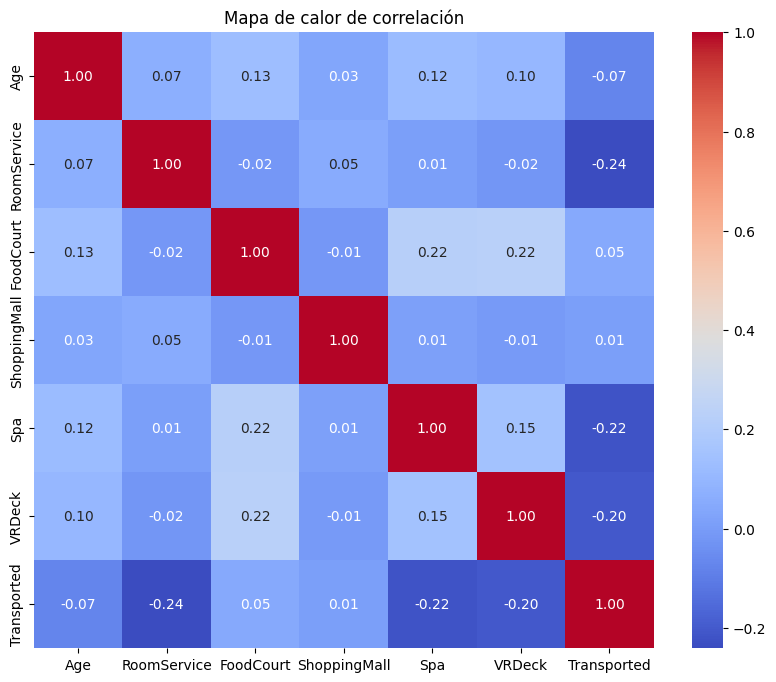

In [ ]:
num_cols = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
corr_matrix = train[num_cols + ['Transported']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Mapa de calor de correlación')
plt.show()

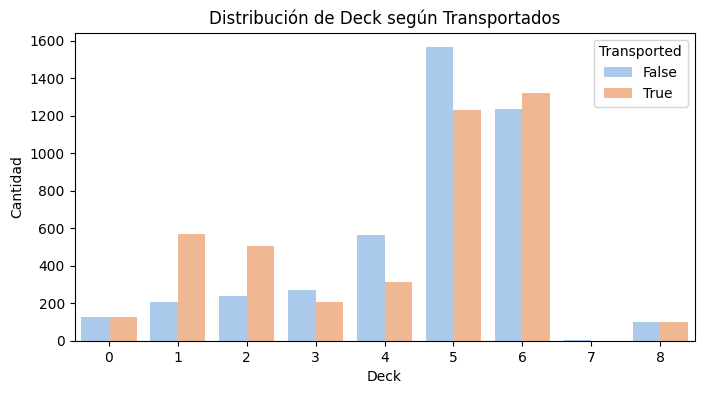

In [ ]:
plt.figure(figsize=(8, 4))
sns.countplot(data=train, x='Deck', hue='Transported', palette='pastel')
plt.title('Distribución de Deck según Transportados')
plt.xlabel('Deck')
plt.ylabel('Cantidad')
plt.show()

## Modelos

Dividimos la data en conjunto de entrenamiento y validación.

In [ ]:
X = train.drop('Transported', axis=1)
y = train['Transported'].astype(int)
X_test = test

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### Modelo Random Forest

Creamos el modelo

In [ ]:
rf_model = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=10, min_samples_leaf=4, min_samples_split=2)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_val)
dump(rf_model, 'random_forest_model.joblib')

['random_forest_model.joblib']

Asignamos las métricas

In [ ]:
rf_metrics = {
    "Accuracy": accuracy_score(y_val, rf_pred),
    "F1-Score": f1_score(y_val, rf_pred),
    "ROC-AUC": roc_auc_score(y_val, rf_pred),
    "Precision": precision_score(y_val, rf_pred),
    "Recall": recall_score(y_val, rf_pred)
}

In [ ]:
print("Random Forest Metrics:")
for metric, value in rf_metrics.items():
    print(f"{metric}: {value}")

Random Forest Metrics:
Accuracy: 0.7998849913743531
F1-Score: 0.8029445073612684
ROC-AUC: 0.7998136213802335
Precision: 0.7966292134831461
Recall: 0.8093607305936074


Realizamos una busqueda de hiperparámetros

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

grid_search.fit(X, y)
print("Mejores hiperparámetros:", grid_search.best_params_)

Mejores hiperparámetros: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}


In [ ]:
best_params = grid_search.best_params_
best_model = RandomForestClassifier(**best_params, random_state=42)
best_model.fit(X_train, y_train)
rf_pred = best_model.predict(X_val)

print("Random Forest Best Model Metrics:")
for metric, value in rf_metrics.items():
    print(f"{metric}: {value}")

Random Forest Best Model Metrics:
Accuracy: 0.7998849913743531
F1-Score: 0.8029445073612684
ROC-AUC: 0.7998136213802335
Precision: 0.7966292134831461
Recall: 0.8093607305936074


###Modelo KGBoost

In [ ]:
xg_model = xgb.XGBClassifier(random_state=42, n_estimators=100, max_depth=10, learning_rate=0.1)
xg_model.fit(X_train, y_train)
xg_pred = xg_model.predict(X_val)
dump(xg_model, 'linear_regression_model.joblib')

['linear_regression_model.joblib']

Asignamos las metricas

In [ ]:
xg_metrics = {
    "Accuracy": accuracy_score(y_val, xg_pred),
    "F1-Score": f1_score(y_val, xg_pred),
    "ROC-AUC": roc_auc_score(y_val, xg_pred),
    "Precision": precision_score(y_val, xg_pred),
    "Recall": recall_score(y_val, xg_pred)
}

In [ ]:
print("XGBoost Metrics:")
for metric, value in xg_metrics.items():
    print(f"{metric}: {value}")

XGBoost Metrics:
Accuracy: 0.8113858539390454
F1-Score: 0.8088578088578089
ROC-AUC: 0.8115300771969925
Precision: 0.8261904761904761
Recall: 0.7922374429223744


###Modelo Logistic Regression

In [ ]:
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_val)
dump(lr_model, 'linear_regression_model.joblib')

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


['linear_regression_model.joblib']

Asignamos las metricas

In [ ]:
lr_metrics = {
    "Accuracy": accuracy_score(y_val, lr_pred),
    "F1-Score": f1_score(y_val, lr_pred),
    "ROC-AUC": roc_auc_score(y_val, lr_pred),
    "Precision": precision_score(y_val, lr_pred),
    "Recall": recall_score(y_val, lr_pred)
}

In [ ]:
print("Linear Regression Metrics:")
for metric, value in lr_metrics.items():
    print(f"{metric}: {value}")

Linear Regression Metrics:
Accuracy: 0.78953421506613
F1-Score: 0.7941507311586051
ROC-AUC: 0.789410678476378
Precision: 0.7827050997782705
Recall: 0.8059360730593608


### Modelo LightGBM

In [ ]:
# Convertir 'VIP' a bool (si es categórica)
X_train['VIP'] = X_train['VIP'].astype(bool)
X_val['VIP'] = X_val['VIP'].astype(bool)
X_test['VIP'] = X_test['VIP'].astype(bool)

# Convertir 'Num' a float (si es numérica)
X_train['Num'] = pd.to_numeric(X_train['Num'], errors='coerce').fillna(0).astype(float)
X_val['Num'] = pd.to_numeric(X_val['Num'], errors='coerce').fillna(0).astype(float)
X_test['Num'] = pd.to_numeric(X_test['Num'], errors='coerce').fillna(0).astype(float)

In [ ]:
lgb_model = LGBMClassifier(random_state=42, n_estimators=100, max_depth=10)
lgb_model.fit(X_train, y_train)
lgb_pred = lgb_model.predict(X_val)
dump(lgb_model, 'lightgbm_model.joblib')

[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001799 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1632
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380


['lightgbm_model.joblib']

In [ ]:
lgb_metrics = {
    "Accuracy": accuracy_score(y_val, lgb_pred),
    "F1-Score": f1_score(y_val, lgb_pred),
    "ROC-AUC": roc_auc_score(y_val, lgb_pred),
    "Precision": precision_score(y_val, lgb_pred),
    "Recall": recall_score(y_val, lgb_pred)
}

In [ ]:
print("LightGBM Metrics:")
for metric, value in lgb_metrics.items():
    print(f"{metric}: {value}")

LightGBM Metrics:
Accuracy: 0.8159861989649224
F1-Score: 0.8175598631698974
ROC-AUC: 0.8159673169415389
Precision: 0.816628701594533
Recall: 0.8184931506849316


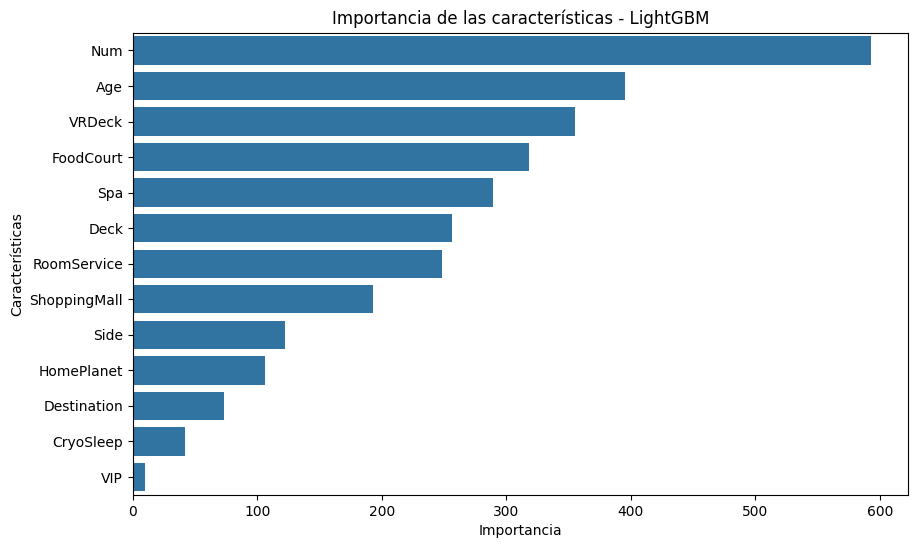

In [ ]:
# Importancia de características
feature_importances = lgb_model.feature_importances_
features = X.columns

# Ordenar por importancia
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_features = features[sorted_indices]
sorted_importances = feature_importances[sorted_indices]

# Graficar
plt.figure(figsize=(10, 6))
sns.barplot(x=sorted_importances, y=sorted_features, orient='h')
plt.title("Importancia de las características - LightGBM")
plt.xlabel("Importancia")
plt.ylabel("Características")
plt.show()

In [ ]:
comparison = pd.DataFrame([rf_metrics, lgb_metrics, lr_metrics, xg_metrics], index=['Random Forest', 'LightGBM', 'Logistic Regression', 'XGBoost'])

# Mostrar tabla comparativa
print(comparison)

                     Accuracy  F1-Score   ROC-AUC  Precision    Recall
Random Forest        0.799885  0.802945  0.799814   0.796629  0.809361
LightGBM             0.815986  0.817560  0.815967   0.816629  0.818493
Logistic Regression  0.789534  0.794151  0.789411   0.782705  0.805936
XGBoost              0.811386  0.808858  0.811530   0.826190  0.792237


## Conclusiones

Conclusiones del proyecto Spaceship Titanic

    Insights sobre los pasajeros:
        Se observó una correlación entre el estado de criogenización (CryoSleep) y la probabilidad de ser transportado a otra dimensión. Esto sugiere que esta condición puede haber influido en cómo la anomalía afectó a los pasajeros.
        Los pasajeros VIP parecen tener una probabilidad ligeramente mayor de sobrevivir o evitar ser transportados, aunque este resultado podría requerir un análisis más profundo para confirmar su validez.

    Eficiencia de los modelos utilizados:
        Los modelos de clasificación, como Random Forest y LightGBM, lograron resultados notables, destacando el LightGBM con métricas como un accuracy de 81.6% y un F1-Score de 81.7%. Estas métricas reflejan la capacidad del modelo para distinguir correctamente entre los pasajeros transportados y no transportados.
        El uso de métricas adicionales como ROC-AUC y Precision ayudó a garantizar que el modelo no solo fuera preciso, sino también robusto para identificar casos positivos.

    Impacto del análisis de datos:
        Las visualizaciones realizadas mostraron patrones interesantes en la distribución de pasajeros según su planeta de origen (HomePlanet) y destino (Destination), lo que permitió entender mejor las características clave para predecir el transporte.
        La limpieza y estructuración de los datos fueron esenciales para obtener estos resultados, especialmente dado el manejo de valores nulos y datos inconsistentes.

    Logros del proyecto:
        Se logró construir un modelo predictivo efectivo para identificar qué pasajeros fueron transportados por la anomalía.
        Este análisis tiene implicaciones significativas para futuras misiones espaciales, ayudando a identificar posibles riesgos y optimizar la seguridad de los pasajeros.

    Líneas futuras:
        Investigar otras características que puedan influir en el transporte, como interacciones entre variables.
        Considerar el uso de modelos más avanzados, como redes neuronales, para mejorar aún más las predicciones.